In [1]:
require(data.table)
require(ggplot2)
require(viridis)
require(RColorBrewer)
source("functions/save_and_plot.R")

Loading required package: data.table

Loading required package: ggplot2

Loading required package: viridis

Loading required package: viridisLite

Loading required package: RColorBrewer



In [2]:
pdata = fread("../data/Tier_2_detection_efficiency_per_replicate_chrX_46plex_eLIT.csv")[, V1 := NULL]

In [3]:
set.seed(465456)
pdata[Deconvolution == "Non DW", Deconvolution := "RL"]
pdata[, Deconvolution := factor(Deconvolution, levels=c("RL", "DW"))]
pdata[, category := factor(category, levels=c("OFQv68_w2", "OFQv68_w3", "OFQv68_w4", "OFQv68_w3_BS", "OFQv68_w4_BS", "OFQv69_w4", "OFQv69_w5"))]
pdata[, nudge_x := runif(.N, -.125, .125)]

Loading required package: boot



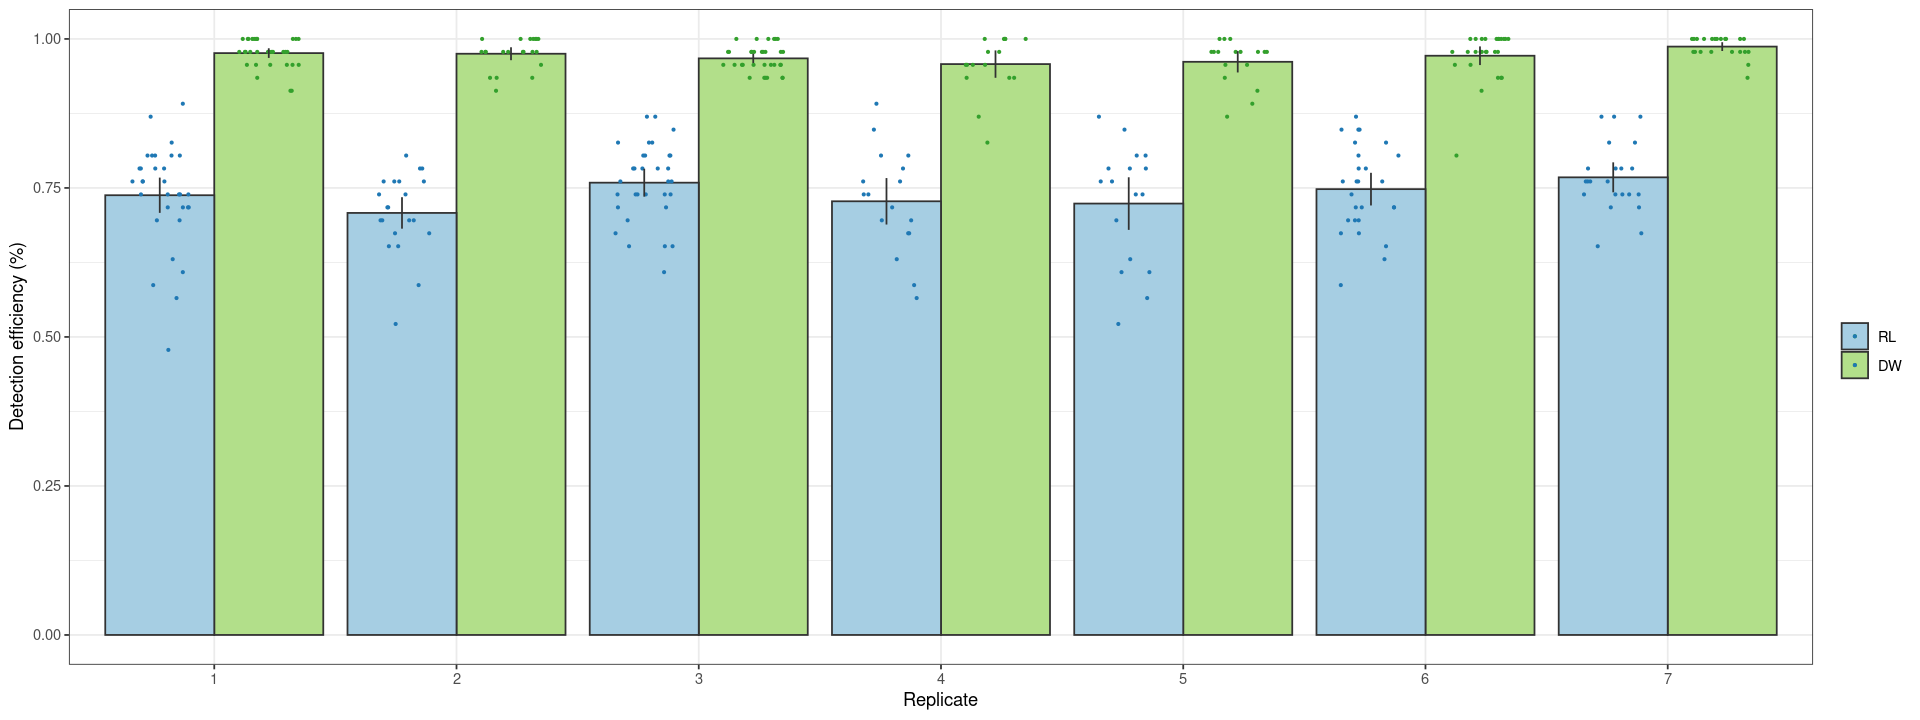

In [4]:
options(repr.plot.width=16, repr.plot.height=6)
palette = brewer.pal(4, "Paired")

require(boot)
set.seed(424654)
mean.fun = function(data, idx) { mean(data[idx]) }
stat_data = pdata[, .(mean=mean(detected), sd=sd(detected), ci=diff(unlist(boot.ci(boot.out=boot(detected, mean.fun, R=1000), type=c("perc"))$percent)[4:5])/2), by=c("category", "Deconvolution")]

p = ggplot(stat_data, aes(x=factor(category), y=mean, fill=Deconvolution)) +
    geom_col(position="dodge", color="#323232") +
    theme_bw() + scale_fill_manual("", values=palette[c(1,3)]) +
    scale_x_discrete(labels=1:7) + labs(x="Replicate", y="Detection efficiency (%)") +
    geom_point(data=pdata[Deconvolution == "DW"],
               aes(x=as.numeric(factor(category))+.225+nudge_x, y=detected),
               color=palette[4], size=.5) +
    geom_point(data=pdata[Deconvolution == "RL"],
               aes(x=as.numeric(factor(category))-.225+nudge_x, y=detected),
               color=palette[2], size=.5) +
    geom_errorbar(data=stat_data[Deconvolution == "DW"],
                  aes(x=as.numeric(factor(category))+.225, ymax=mean+ci, ymin=mean-ci),
                  color="#323232", width=0, size=.5) +
    geom_errorbar(data=stat_data[Deconvolution == "RL"],
                  aes(x=as.numeric(factor(category))-.225, ymax=mean+ci, ymin=mean-ci),
                  color="#323232", width=0, size=.5)
print(p)

In [5]:
save_and_plot(p, "panels/fig_5c", width=8, height=2.5, formats=c("png", "jpg", "pdf"))
saveRDS(p, "panels/fig_5c.rds")

In [6]:
bs = boot(pdata[Deconvolution == "DW", detected], mean.fun, R=1000)
ci = boot.ci(boot.out=bs, type=c("perc"))
sprintf("%.1f += %.1f %%", bs$t0*100, diff(unlist(ci$percent)[4:5])/2*100)

bs = boot(pdata[Deconvolution == "RL", detected], mean.fun, R=1000)
ci = boot.ci(boot.out=bs, type=c("perc"))
sprintf("%.1f += %.1f %%", bs$t0*100, diff(unlist(ci$percent)[4:5])/2*100)


[1] "97.2 += 0.5 %"

[1] "74.1 += 1.2 %"